<a href="https://colab.research.google.com/github/joshtan0710/HP_Data_Science/blob/master/Object_Detection_Uplevel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import os 
import re
import cv2
import numpy as np 
from os.path import isfile,join
import matplotlib.pyplot as plt


In [2]:
result = re.sub('\d', '', '156161dfagdkgmks25')
print(result)

dfagdkgmks


In [3]:
# declare path for names
col_frames = os.listdir('/content/drive/MyDrive/Datasets/frames')

In [4]:
#sort file names, regex sorting 
# f refers to input 
col_frames.sort(key = lambda f:int(re.sub('\D', '',f)))  # \D matches any single character that is not a digit 

In [5]:
# create an empty list to store images
col_images = []

for frame in col_frames:
  # Read Frames
  temp_img = cv2.imread('/content/drive/MyDrive/Datasets/frames/' + frame) # reads to an array
  col_images.append(temp_img)

In [6]:
#take a look at first item 
col_images[0].shape

(144, 256, 3)

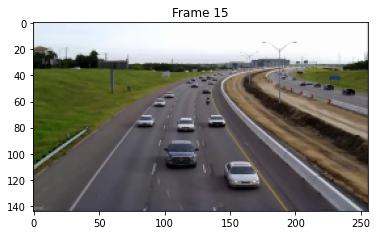

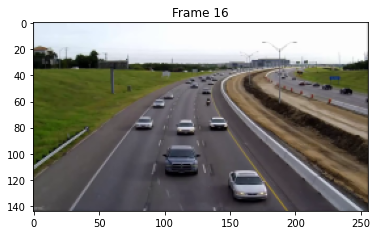

In [7]:
# visualising image
num = 15
for frame in [num, num+1]:
  plt.imshow(cv2.cvtColor(col_images[frame],cv2.COLOR_BGR2RGB))  # want to change color channels
  plt.title(f'Frame {frame}')
  plt.show()  # displays each plot

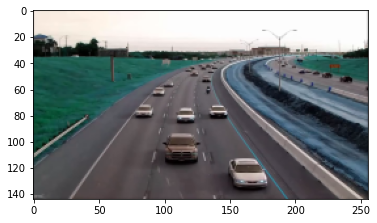

In [8]:
# visualising image, why were the color channels in BGR?
num = 15
for frame in [num, num+1]:
  plt.imshow(col_images[frame])

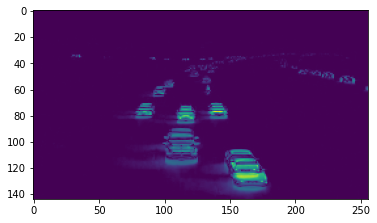

In [9]:
# how to convert image to greyscale
grayA = cv2.cvtColor(col_images[num], cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(col_images[num+1], cv2.COLOR_BGR2GRAY)

# plot the image after frame differencing
# notice how stationary objects will be cancelled out 
plt.imshow(cv2.absdiff(grayB, grayA)) #, cmap ='gray'

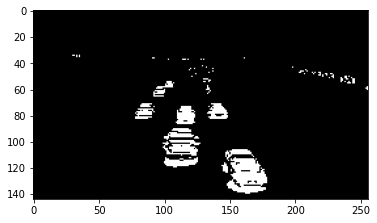

In [10]:
# save the diff into a variable 
diff_image = (cv2.absdiff(grayB, grayA))

#image thresholding, want to remove shadows(low_intensity) as it might distort bounding boxes
#thresh_binary is when pixel value is >30, update it to max intensity
#thresh_otsu for complex images
ret, thresh = cv2.threshold(diff_image, 30,255,cv2.THRESH_BINARY)
plt.imshow(thresh,cmap = 'gray')
plt.show()

[[1 1 1]
 [1 1 1]
 [1 1 1]]


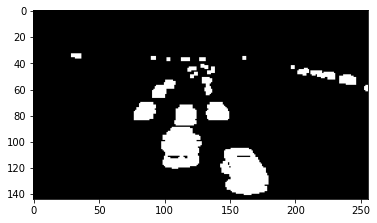

In [11]:
# how to draw accurate bounding boxes? 
# reduce resolution using image dilation, i.e. retains quality but less clear 

kernel = np.ones((3,3), np.uint8)
print(kernel)

dilated = cv2.dilate(thresh, kernel, iterations=1) # tune iteration & kernel *****
plt.imshow(dilated, cmap = 'gray')
plt.show()

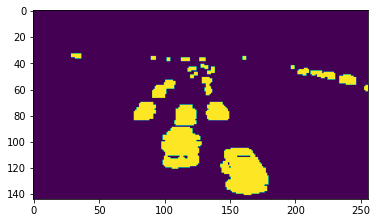

In [12]:
# plot a vehicle detection zone

plt.imshow(dilated)
cv2.line(dilated, (0,80), (256,80), (256,0,0), thickness = 2)  #start point, end point,color, thickness
plt.show()

In [13]:
# Contours are the boundaries of a shape with same intensity.
# It stores the (x,y) coordinates of the boundary of a shape.
#cv2.findContours using appropriate algorithms.
#cv2.CHAIN_APPROX_NONE stores all boundary points, but do we need all?

contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

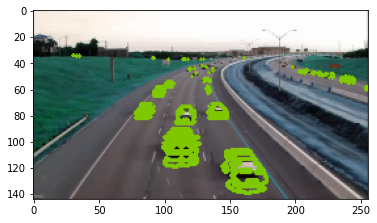

In [14]:
#next we can drawContours
temp_copy = col_images[15].copy()
cv2.drawContours(temp_copy, contours,-1, (127,200,0),2)  # index of contours,color of line, thickness of line
plt.imshow(temp_copy)
plt.show()

#not good because it is finding too many contours

In [15]:
len(contours)

79

In [16]:
#declare list of valid contours

valid_contours = []

for i, con in enumerate(contours):
  x,y,w,h = cv2.boundingRect(con)
  if (x<=200) & (y>=80) & (cv2.contourArea(con) >=25):
    valid_contours.append(con)

In [17]:
len(valid_contours)

7

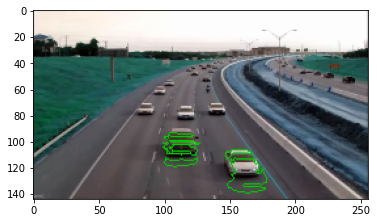

In [18]:
temp_copy = col_images[15].copy()
cv2.drawContours(temp_copy, valid_contours,-1, (0,200,0),1)  # index of contours,color of line, thickness of line
plt.imshow(temp_copy)
plt.show()

In [19]:
#reduce resolution using image dilation 
kernel = np.ones((4,4), np.uint8)

#declare a pathIn to save the output frames
pathIn = '/content/drive/MyDrive/Datasets/Output_frames/' #need a / at the end

#font
font = cv2.FONT_HERSHEY_SIMPLEX


In [20]:
pwd

'/content'

In [21]:
#function that does all the things together 

for img in range(len(col_images)-1):

  #do frame differencing
  grayA = cv2.cvtColor(col_images[img], cv2.COLOR_BGR2GRAY)
  grayB = cv2.cvtColor(col_images[img+1], cv2.COLOR_BGR2GRAY)
  diff_image = (cv2.absdiff(grayB, grayA))

  #thresholding
  ret, thresh = cv2.threshold(diff_image, 30,255,cv2.THRESH_BINARY)
  
  #dilation
  dilated = cv2.dilate(thresh, kernel, iterations=1)

  #find all contours
  contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

  #find valid contours
  valid_contours = []

  for i, con in enumerate(contours):
    x,y,w,h = cv2.boundingRect(con)
    if (x<=200) & (y>=80) & (cv2.contourArea(con) >=25):
      if (y>=90) & (cv2.contourArea(con) <40):  #specific size box ****
        valid_contours.append(con)
  #add contours to original frame
  temp_copy = col_images[img].copy()
  cv2.drawContours(temp_copy, valid_contours,-1, (0,200,0),2)

  #put text on image 
  cv2.putText(temp_copy,"Vehicles Detected: " + str(len(valid_contours)), (55,15), font, 0.6, (0,255,0))
  cv2.line(temp_copy, (0,80), (256,80), (256,0,0), thickness = 2)
  cv2.imwrite(pathIn + str(img)+ '.png',temp_copy )#string, images


In [29]:
pathout = '/content/drive/MyDrive/Datasets/outputvideo.mp4'

#define frames per second 
fps = 14.0

In [23]:
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
files.sort(key = lambda f:int(re.sub('\D', '',f)))

In [24]:
for i in range(len(files)):
  filename = pathIn + files[i]

  #read frames 
  img = cv2.imread(filename)
  height,width,dims = img.shape
  size = (width, height)#take note of size 

  #inserting the frames into an image array
  frame_array.append(img)
frame_array[0].shape



(144, 256, 3)

In [25]:
#init videowriter
out = cv2.VideoWriter(pathout, cv2.VideoWriter_fourcc(*'DIVX'), fps,size)

#write images to form video
for i in range(len(frame_array)):
  out.write(frame_array[i])
out.release()